# Fashion MNIST - Neural Networks Coursework
**Roll Number:** P2929935

**Student Name:** Faseeh Bin Ali

This notebook compares two approaches for image classification:
- **ANN (Multi-Layer Perceptron)**: Traditional fully-connected network
- **CNN (Convolutional Network)**: Uses convolutional layers to learn spatial features

Dataset: Fashion-MNIST (60k train, 10k test images of 10 clothing types)

---


In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  # hide deprecation warnings

# Set random seeds for reproducible results
# This ensures we get same results each time we run
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available - training is much faster on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Device: cuda
GPU: Tesla T4


In [2]:
# Fashion-MNIST has 10 clothing categories
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Hyperparameters - these worked well after experimentation
batch_size = 128    # number of images per batch (tried 64, 128, 256)
epochs = 18         # number of training passes through data
lr = 0.001          # learning rate (0.01 too high, 0.0001 too slow)
dropout = 0.3       # dropout rate to prevent overfitting


## Data Loading and Preprocessing

Fashion-MNIST images need to be normalized for better training.
We calculate mean and std from the training set and use those values.

In [3]:
# Normalization statistics for Fashion-MNIST
# These values were calculated from the full training set
mean = 0.2860  # average pixel value
std = 0.3530   # standard deviation

# Transform pipeline: convert to tensor and normalize
# Normalization formula: (pixel - mean) / std
# This centers data around 0 and helps training converge faster
transform = transforms.Compose([
    transforms.ToTensor(),              # converts PIL image to tensor [0,1]
    transforms.Normalize((mean,), (std,))  # normalizes to ~[-1,1]
])

# Download and load Fashion-MNIST dataset
print("Downloading data...")
train_data = torchvision.datasets.FashionMNIST(
    root='./data',           # save location
    train=True,              # get training set
    download=True,           # download if not present
    transform=transform      # apply our transform
)

test_data = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,             # get test set
    download=True,
    transform=transform
)

# Split training data into train (90%) and validation (10%)
# Validation set helps us tune hyperparameters without touching test set
train_size = int(0.9 * len(train_data))  # 54,000 images
val_size = len(train_data) - train_size   # 6,000 images
train_set, val_set = random_split(
    train_data,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # reproducible split
)

# Create data loaders - these feed batches to our models
# shuffle=True for training helps model generalize better
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_data)}")


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 32.1MB/s]

Train: 54000, Val: 6000, Test: 10000


Batch shape: torch.Size([128, 1, 28, 28])
Label shape: torch.Size([128])


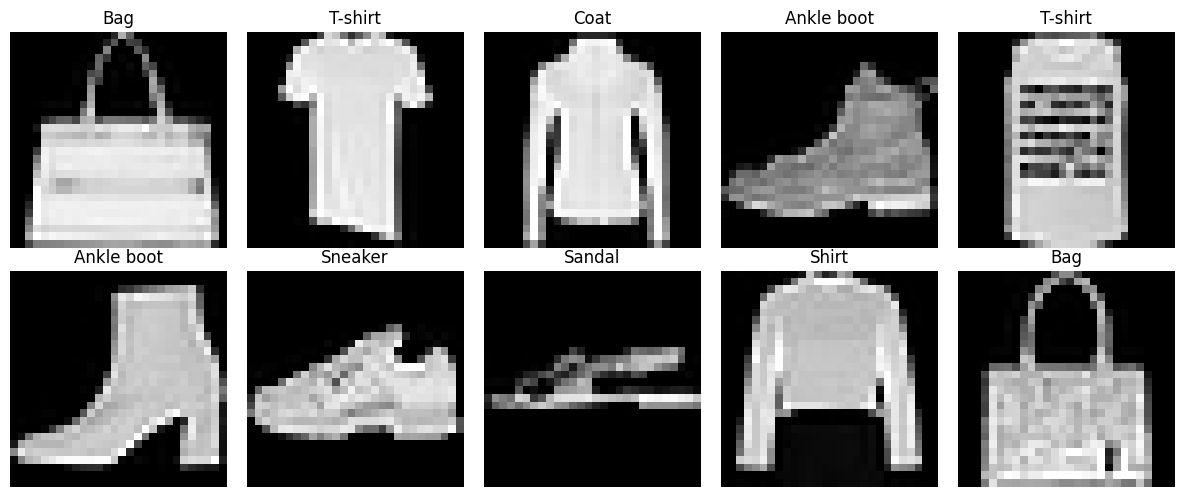

In [4]:
# Visualize some sample images to understand the data
imgs, labels = next(iter(train_loader))
print(f"Batch shape: {imgs.shape}")    # should be [128, 1, 28, 28]
print(f"Label shape: {labels.shape}")  # should be [128]

# Display first 10 images from the batch
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img = imgs[i].squeeze() * std + mean  # denormalize to see actual image
    ax.imshow(img, cmap='gray')
    ax.set_title(classes[labels[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()


## ANN Model (Multi-Layer Perceptron)

Traditional neural network with fully-connected layers.
- Flattens 28x28 image into 784-dimensional vector
- 3 hidden layers with decreasing size: 512 → 256 → 128
- Uses ReLU activation, batch norm, and dropout

In [5]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()

        # Layer 1: 784 inputs (28x28) → 512 neurons
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)  # normalizes activations
        self.drop1 = nn.Dropout(dropout)  # randomly drop neurons

        # Layer 2: 512 → 256 neurons
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(dropout)

        # Layer 3: 256 → 128 neurons
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.drop3 = nn.Dropout(dropout)

        # Output layer: 128 → 10 classes
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        # Flatten image from [batch, 1, 28, 28] to [batch, 784]
        x = x.view(-1, 28*28)

        # Pass through layers with ReLU activation
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)

        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)

        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.drop3(x)

        x = self.fc4(x)  # no activation on output (handled by loss)
        return x

# Create model and move to GPU/CPU
ann = ANN().to(device)

# Count total trainable parameters
total_params = sum(p.numel() for p in ann.parameters())
print(f"ANN parameters: {total_params:,}")


ANN parameters: 569,226


## CNN Model (Convolutional Neural Network)

Uses convolutional layers to learn spatial features from images.
- 3 conv blocks with increasing channels: 32 → 64 → 128
- Max pooling reduces spatial dimensions
- Should work better than ANN for images!

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Block 1: 1 → 32 channels
        # Two 3x3 conv layers extract basic features (edges, textures)
        self.conv1a = nn.Conv2d(1, 32, 3, padding=1)   # keeps size 28x28
        self.conv1b = nn.Conv2d(32, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)      # reduces to 14x14
        self.drop1 = nn.Dropout2d(0.15)   # spatial dropout

        # Convolutional Block 2: 32 → 64 channels
        # Learns more complex patterns
        self.conv2a = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)      # reduces to 7x7
        self.drop2 = nn.Dropout2d(0.15)

        # Convolutional Block 3: 64 → 128 channels
        # Learns high-level features
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)      # reduces to 3x3

        # Fully connected layers for classification
        # 128 channels * 3x3 = 1152 features
        self.fc1 = nn.Linear(128*3*3, 128)
        self.bn_fc = nn.BatchNorm1d(128)
        self.drop_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 10)     # output 10 classes

    def forward(self, x):
        # Block 1: extract basic features
        x = torch.relu(self.conv1a(x))
        x = torch.relu(self.bn1(self.conv1b(x)))
        x = self.pool1(x)  # downsample
        x = self.drop1(x)

        # Block 2: learn intermediate features
        x = torch.relu(self.conv2a(x))
        x = torch.relu(self.bn2(self.conv2b(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        # Block 3: learn high-level features
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        # Flatten and classify
        x = x.view(x.size(0), -1)  # flatten to [batch, 1152]
        x = torch.relu(self.bn_fc(self.fc1(x)))
        x = self.drop_fc(x)
        x = self.fc2(x)
        return x

# Create CNN and move to device
cnn = CNN().to(device)

# Count parameters
cnn_params = sum(p.numel() for p in cnn.parameters())
ann_params = sum(p.numel() for p in ann.parameters())
print(f"CNN parameters: {cnn_params:,}")
print(f"Parameter reduction: {(1 - cnn_params / ann_params) * 100:.1f}%")


CNN parameters: 288,426
Parameter reduction: 49.3%


## Training Function

Trains a model for specified number of epochs.
Uses Adam optimizer and learning rate scheduling.

In [7]:
def train_model(model, name, num_epochs=18):
    """
    Train a neural network model

    Args:
        model: The neural network to train
        name: Name for printing (e.g., 'ANN', 'CNN')
        num_epochs: Number of training epochs

    Returns:
        history: Dictionary with training/validation metrics
    """
    # Setup training components
    criterion = nn.CrossEntropyLoss()  # loss function for classification
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Reduce learning rate when validation accuracy plateaus
    # This helps fine-tune the model
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'max',      # maximize validation accuracy
        factor=0.5,            # halve the learning rate
        patience=3             # wait 3 epochs before reducing
    )

    # Track metrics over time
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    best_acc = 0

    print(f"\nTraining {name}...")
    start = time.time()

    for epoch in range(num_epochs):
        # === Training Phase ===
        model.train()  # enable dropout and batch norm training mode
        train_loss = 0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            # Move data to GPU/CPU
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()       # clear gradients
            outputs = model(imgs)       # get predictions
            loss = criterion(outputs, labels)  # calculate loss

            # Backward pass
            loss.backward()             # compute gradients
            optimizer.step()            # update weights

            # Track statistics
            train_loss += loss.item()
            _, pred = outputs.max(1)    # get predicted class
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

        # Calculate average loss and accuracy
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total

        # === Validation Phase ===
        model.eval()  # disable dropout, use batch norm running stats
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # don't compute gradients for validation
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, pred = outputs.max(1)
                total += labels.size(0)
                correct += pred.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total

        # Update learning rate based on validation performance
        scheduler.step(val_acc)

        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Track best validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    elapsed = time.time() - start
    print(f"Training done in {elapsed:.1f}s. Best val acc: {best_acc:.2f}%")
    return history


## Train ANN Model
This will take about 5 minutes

In [8]:
# Train the ANN
ann_history = train_model(ann, "ANN", epochs)



Training ANN...
Epoch 1/18 - Train Loss: 0.5484, Acc: 81.39% | Val Loss: 0.3907, Acc: 86.00%
Epoch 2/18 - Train Loss: 0.4057, Acc: 85.34% | Val Loss: 0.3535, Acc: 87.35%
Epoch 3/18 - Train Loss: 0.3645, Acc: 86.86% | Val Loss: 0.3376, Acc: 87.78%
Epoch 4/18 - Train Loss: 0.3394, Acc: 87.69% | Val Loss: 0.3396, Acc: 87.33%
Epoch 5/18 - Train Loss: 0.3254, Acc: 88.14% | Val Loss: 0.3207, Acc: 88.53%
Epoch 6/18 - Train Loss: 0.3111, Acc: 88.72% | Val Loss: 0.3035, Acc: 88.97%
Epoch 7/18 - Train Loss: 0.2960, Acc: 89.13% | Val Loss: 0.3017, Acc: 88.92%
Epoch 8/18 - Train Loss: 0.2857, Acc: 89.48% | Val Loss: 0.3144, Acc: 88.42%
Epoch 9/18 - Train Loss: 0.2779, Acc: 89.76% | Val Loss: 0.3029, Acc: 88.93%
Epoch 10/18 - Train Loss: 0.2690, Acc: 90.15% | Val Loss: 0.3066, Acc: 88.80%
Epoch 11/18 - Train Loss: 0.2395, Acc: 91.16% | Val Loss: 0.2860, Acc: 89.57%
Epoch 12/18 - Train Loss: 0.2291, Acc: 91.57% | Val Loss: 0.2876, Acc: 89.75%
Epoch 13/18 - Train Loss: 0.2218, Acc: 91.63% | Val Loss

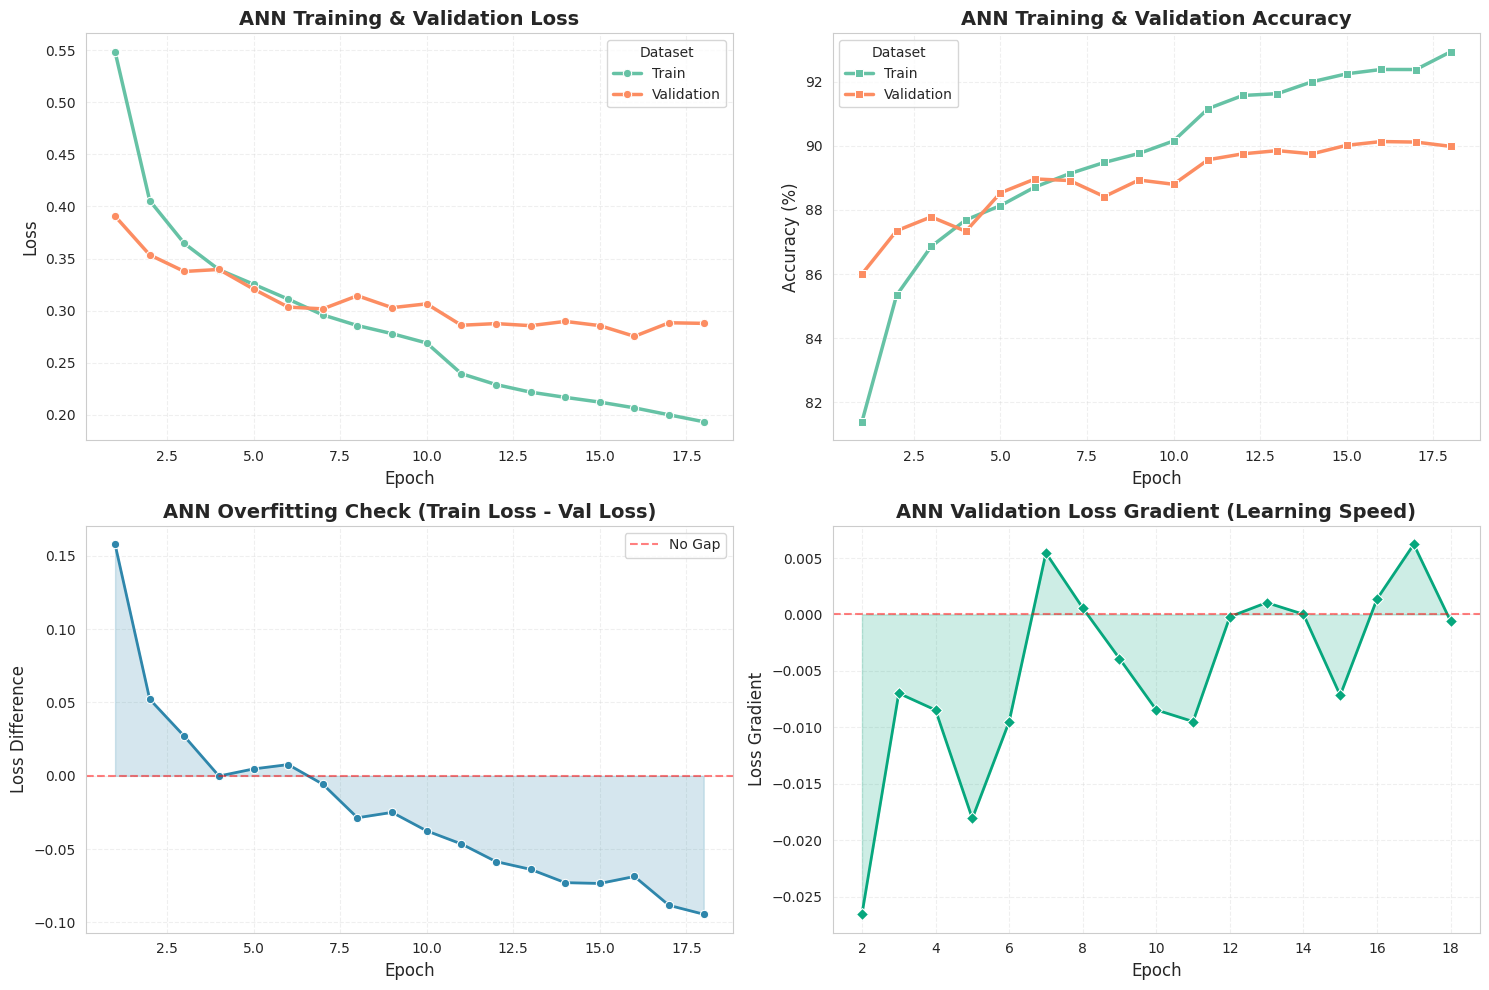


ANN Training Summary:
  Final Train Loss: 0.1934
  Final Val Loss: 0.2878
  Final Train Acc: 92.93%
  Final Val Acc: 89.98%
  Train-Val Loss Gap: 0.0944


In [9]:
# Enhanced ANN Training Curves with Seaborn
# Set seaborn style for better aesthetics
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Prepare data for seaborn
epoch_range = np.arange(1, len(ann_history['train_loss']) + 1)
ann_loss_data = pd.DataFrame({
    'Epoch': np.concatenate([epoch_range, epoch_range]),
    'Loss': np.concatenate([ann_history['train_loss'], ann_history['val_loss']]),
    'Type': ['Train'] * len(epoch_range) + ['Validation'] * len(epoch_range)
})

ann_acc_data = pd.DataFrame({
    'Epoch': np.concatenate([epoch_range, epoch_range]),
    'Accuracy': np.concatenate([ann_history['train_acc'], ann_history['val_acc']]),
    'Type': ['Train'] * len(epoch_range) + ['Validation'] * len(epoch_range)
})

# Create comprehensive loss visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves with seaborn
ax1 = axes[0, 0]
sns.lineplot(data=ann_loss_data, x='Epoch', y='Loss', hue='Type',
             marker='o', markersize=6, linewidth=2.5, ax=ax1)
ax1.set_title('ANN Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(title='Dataset', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Accuracy curves with seaborn
ax2 = axes[0, 1]
sns.lineplot(data=ann_acc_data, x='Epoch', y='Accuracy', hue='Type',
             marker='s', markersize=6, linewidth=2.5, ax=ax2)
ax2.set_title('ANN Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend(title='Dataset', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

# Loss difference (train - val) to check overfitting
ax3 = axes[1, 0]
loss_diff = np.array(ann_history['train_loss']) - np.array(ann_history['val_loss'])
sns.lineplot(x=epoch_range, y=loss_diff, marker='o', color='#2E86AB', linewidth=2, ax=ax3)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No Gap')
ax3.fill_between(epoch_range, loss_diff, 0, alpha=0.2, color='#2E86AB')
ax3.set_title('ANN Overfitting Check (Train Loss - Val Loss)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss Difference', fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, linestyle='--')

# Learning rate effect visualization (loss reduction rate)
ax4 = axes[1, 1]
loss_gradient = np.gradient(ann_history['val_loss'])
sns.lineplot(x=epoch_range[1:], y=loss_gradient[1:], marker='D', color='#06A77D', linewidth=2, ax=ax4)
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax4.fill_between(epoch_range[1:], loss_gradient[1:], 0, alpha=0.2, color='#06A77D')
ax4.set_title('ANN Validation Loss Gradient (Learning Speed)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Loss Gradient', fontsize=12)
ax4.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nANN Training Summary:")
print(f"  Final Train Loss: {ann_history['train_loss'][-1]:.4f}")
print(f"  Final Val Loss: {ann_history['val_loss'][-1]:.4f}")
print(f"  Final Train Acc: {ann_history['train_acc'][-1]:.2f}%")
print(f"  Final Val Acc: {ann_history['val_acc'][-1]:.2f}%")
print(f"  Train-Val Loss Gap: {abs(ann_history['train_loss'][-1] - ann_history['val_loss'][-1]):.4f}")


## Train CNN Model
This may take slightly longer (~6-7 minutes)

In [10]:
# Train the CNN
cnn_history = train_model(cnn, "CNN", epochs)



Training CNN...
Epoch 1/18 - Train Loss: 0.4445, Acc: 84.83% | Val Loss: 0.2799, Acc: 89.65%
Epoch 2/18 - Train Loss: 0.2730, Acc: 90.08% | Val Loss: 0.2436, Acc: 90.70%
Epoch 3/18 - Train Loss: 0.2330, Acc: 91.55% | Val Loss: 0.2178, Acc: 92.10%
Epoch 4/18 - Train Loss: 0.2049, Acc: 92.50% | Val Loss: 0.2093, Acc: 92.10%
Epoch 5/18 - Train Loss: 0.1897, Acc: 93.01% | Val Loss: 0.1922, Acc: 92.72%
Epoch 6/18 - Train Loss: 0.1731, Acc: 93.66% | Val Loss: 0.1927, Acc: 92.93%
Epoch 7/18 - Train Loss: 0.1574, Acc: 94.30% | Val Loss: 0.1986, Acc: 92.30%
Epoch 8/18 - Train Loss: 0.1451, Acc: 94.73% | Val Loss: 0.1880, Acc: 92.93%
Epoch 9/18 - Train Loss: 0.1318, Acc: 95.16% | Val Loss: 0.1832, Acc: 93.70%
Epoch 10/18 - Train Loss: 0.1258, Acc: 95.34% | Val Loss: 0.1854, Acc: 93.48%
Epoch 11/18 - Train Loss: 0.1142, Acc: 95.75% | Val Loss: 0.2014, Acc: 92.87%
Epoch 12/18 - Train Loss: 0.1088, Acc: 95.97% | Val Loss: 0.1941, Acc: 93.17%
Epoch 13/18 - Train Loss: 0.1002, Acc: 96.34% | Val Loss

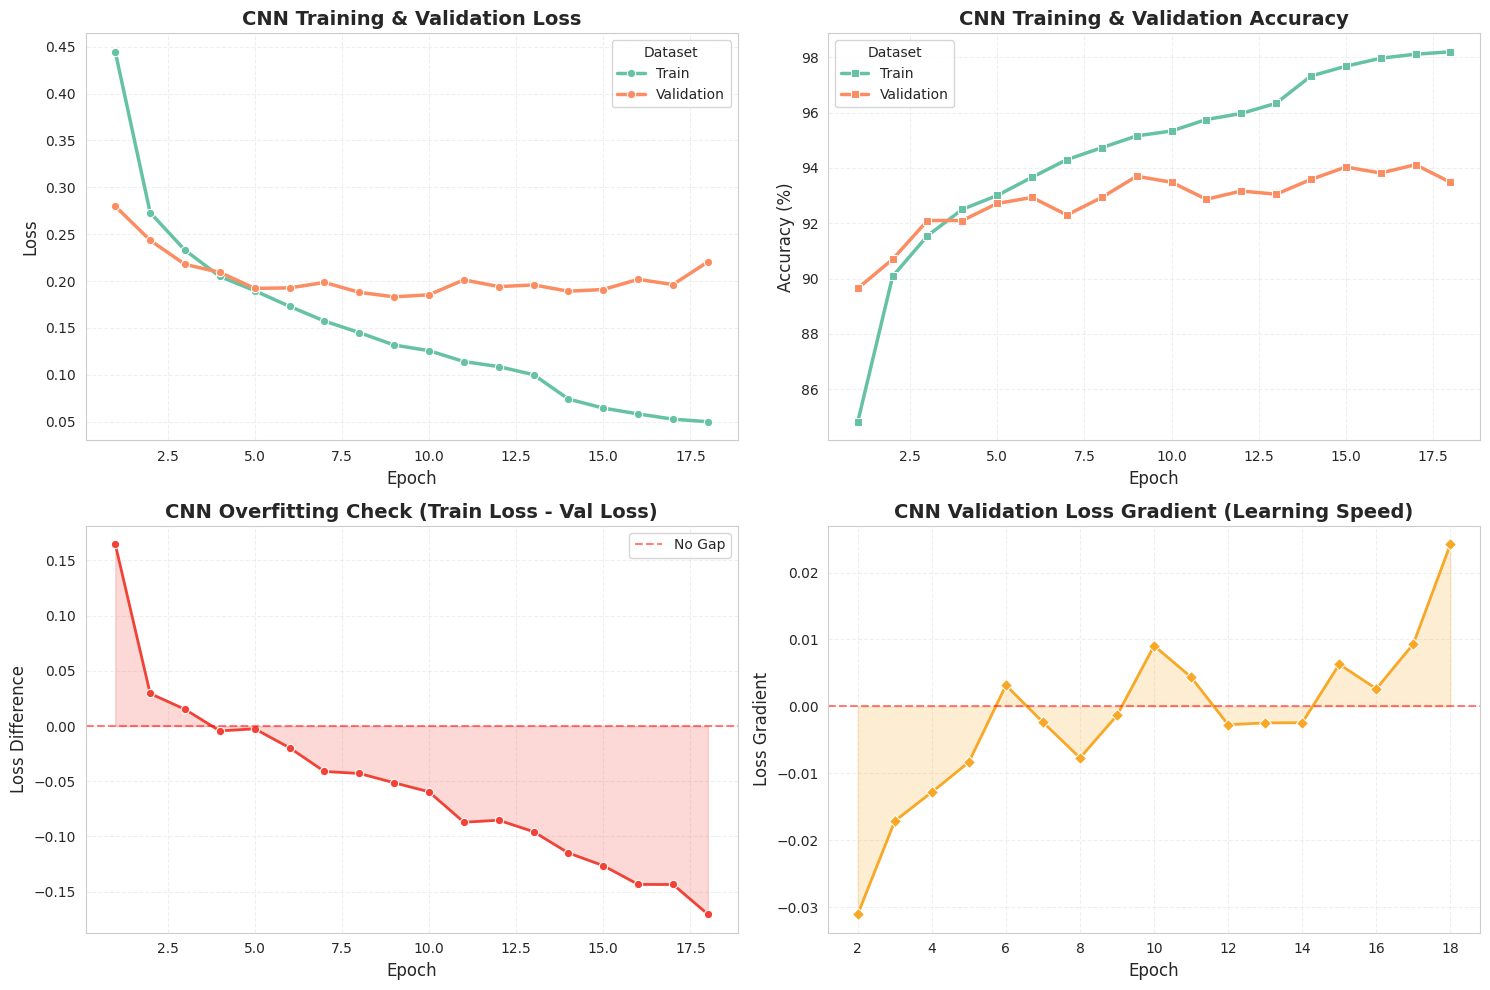


CNN Training Summary:
  Final Train Loss: 0.0500
  Final Val Loss: 0.2205
  Final Train Acc: 98.20%
  Final Val Acc: 93.48%
  Train-Val Loss Gap: 0.1705


In [11]:
# Enhanced CNN Training Curves with Seaborn
# Prepare data for seaborn
epoch_range = np.arange(1, len(cnn_history['train_loss']) + 1)
cnn_loss_data = pd.DataFrame({
    'Epoch': np.concatenate([epoch_range, epoch_range]),
    'Loss': np.concatenate([cnn_history['train_loss'], cnn_history['val_loss']]),
    'Type': ['Train'] * len(epoch_range) + ['Validation'] * len(epoch_range)
})

cnn_acc_data = pd.DataFrame({
    'Epoch': np.concatenate([epoch_range, epoch_range]),
    'Accuracy': np.concatenate([cnn_history['train_acc'], cnn_history['val_acc']]),
    'Type': ['Train'] * len(epoch_range) + ['Validation'] * len(epoch_range)
})

# Create comprehensive loss visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves with seaborn
ax1 = axes[0, 0]
sns.lineplot(data=cnn_loss_data, x='Epoch', y='Loss', hue='Type',
             marker='o', markersize=6, linewidth=2.5, ax=ax1)
ax1.set_title('CNN Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(title='Dataset', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Accuracy curves with seaborn
ax2 = axes[0, 1]
sns.lineplot(data=cnn_acc_data, x='Epoch', y='Accuracy', hue='Type',
             marker='s', markersize=6, linewidth=2.5, ax=ax2)
ax2.set_title('CNN Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend(title='Dataset', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

# Loss difference (train - val) to check overfitting
ax3 = axes[1, 0]
loss_diff = np.array(cnn_history['train_loss']) - np.array(cnn_history['val_loss'])
sns.lineplot(x=epoch_range, y=loss_diff, marker='o', color='#F24236', linewidth=2, ax=ax3)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No Gap')
ax3.fill_between(epoch_range, loss_diff, 0, alpha=0.2, color='#F24236')
ax3.set_title('CNN Overfitting Check (Train Loss - Val Loss)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss Difference', fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, linestyle='--')

# Learning rate effect visualization (loss reduction rate)
ax4 = axes[1, 1]
loss_gradient = np.gradient(cnn_history['val_loss'])
sns.lineplot(x=epoch_range[1:], y=loss_gradient[1:], marker='D', color='#F9A826', linewidth=2, ax=ax4)
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax4.fill_between(epoch_range[1:], loss_gradient[1:], 0, alpha=0.2, color='#F9A826')
ax4.set_title('CNN Validation Loss Gradient (Learning Speed)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Loss Gradient', fontsize=12)
ax4.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nCNN Training Summary:")
print(f"  Final Train Loss: {cnn_history['train_loss'][-1]:.4f}")
print(f"  Final Val Loss: {cnn_history['val_loss'][-1]:.4f}")
print(f"  Final Train Acc: {cnn_history['train_acc'][-1]:.2f}%")
print(f"  Final Val Acc: {cnn_history['val_acc'][-1]:.2f}%")
print(f"  Train-Val Loss Gap: {abs(cnn_history['train_loss'][-1] - cnn_history['val_loss'][-1]):.4f}")


## Evaluation on Test Set

Now test both models on unseen data to get final accuracy

In [12]:
def evaluate(model):
    """
    Evaluate model on test set

    Returns:
        acc: Test accuracy percentage
        y_true: True labels
        y_pred: Predicted labels
    """
    model.eval()
    y_true = []  # store actual labels
    y_pred = []  # store predictions
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, pred = outputs.max(1)  # get class with highest score

            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

            # Save for confusion matrix later
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    acc = 100. * correct / total
    return acc, np.array(y_true), np.array(y_pred)

# Test both models
print("Evaluating models on test set...")
ann_acc, ann_true, ann_pred = evaluate(ann)
print(f"ANN Test Accuracy: {ann_acc:.2f}%")

cnn_acc, cnn_true, cnn_pred = evaluate(cnn)
print(f"CNN Test Accuracy: {cnn_acc:.2f}%")

print(f"\nCNN improvement: +{cnn_acc - ann_acc:.2f}%")


Evaluating models on test set...
ANN Test Accuracy: 89.95%
CNN Test Accuracy: 93.64%

CNN improvement: +3.69%


## Confusion Matrix Analysis

Shows which classes the model confuses with each other

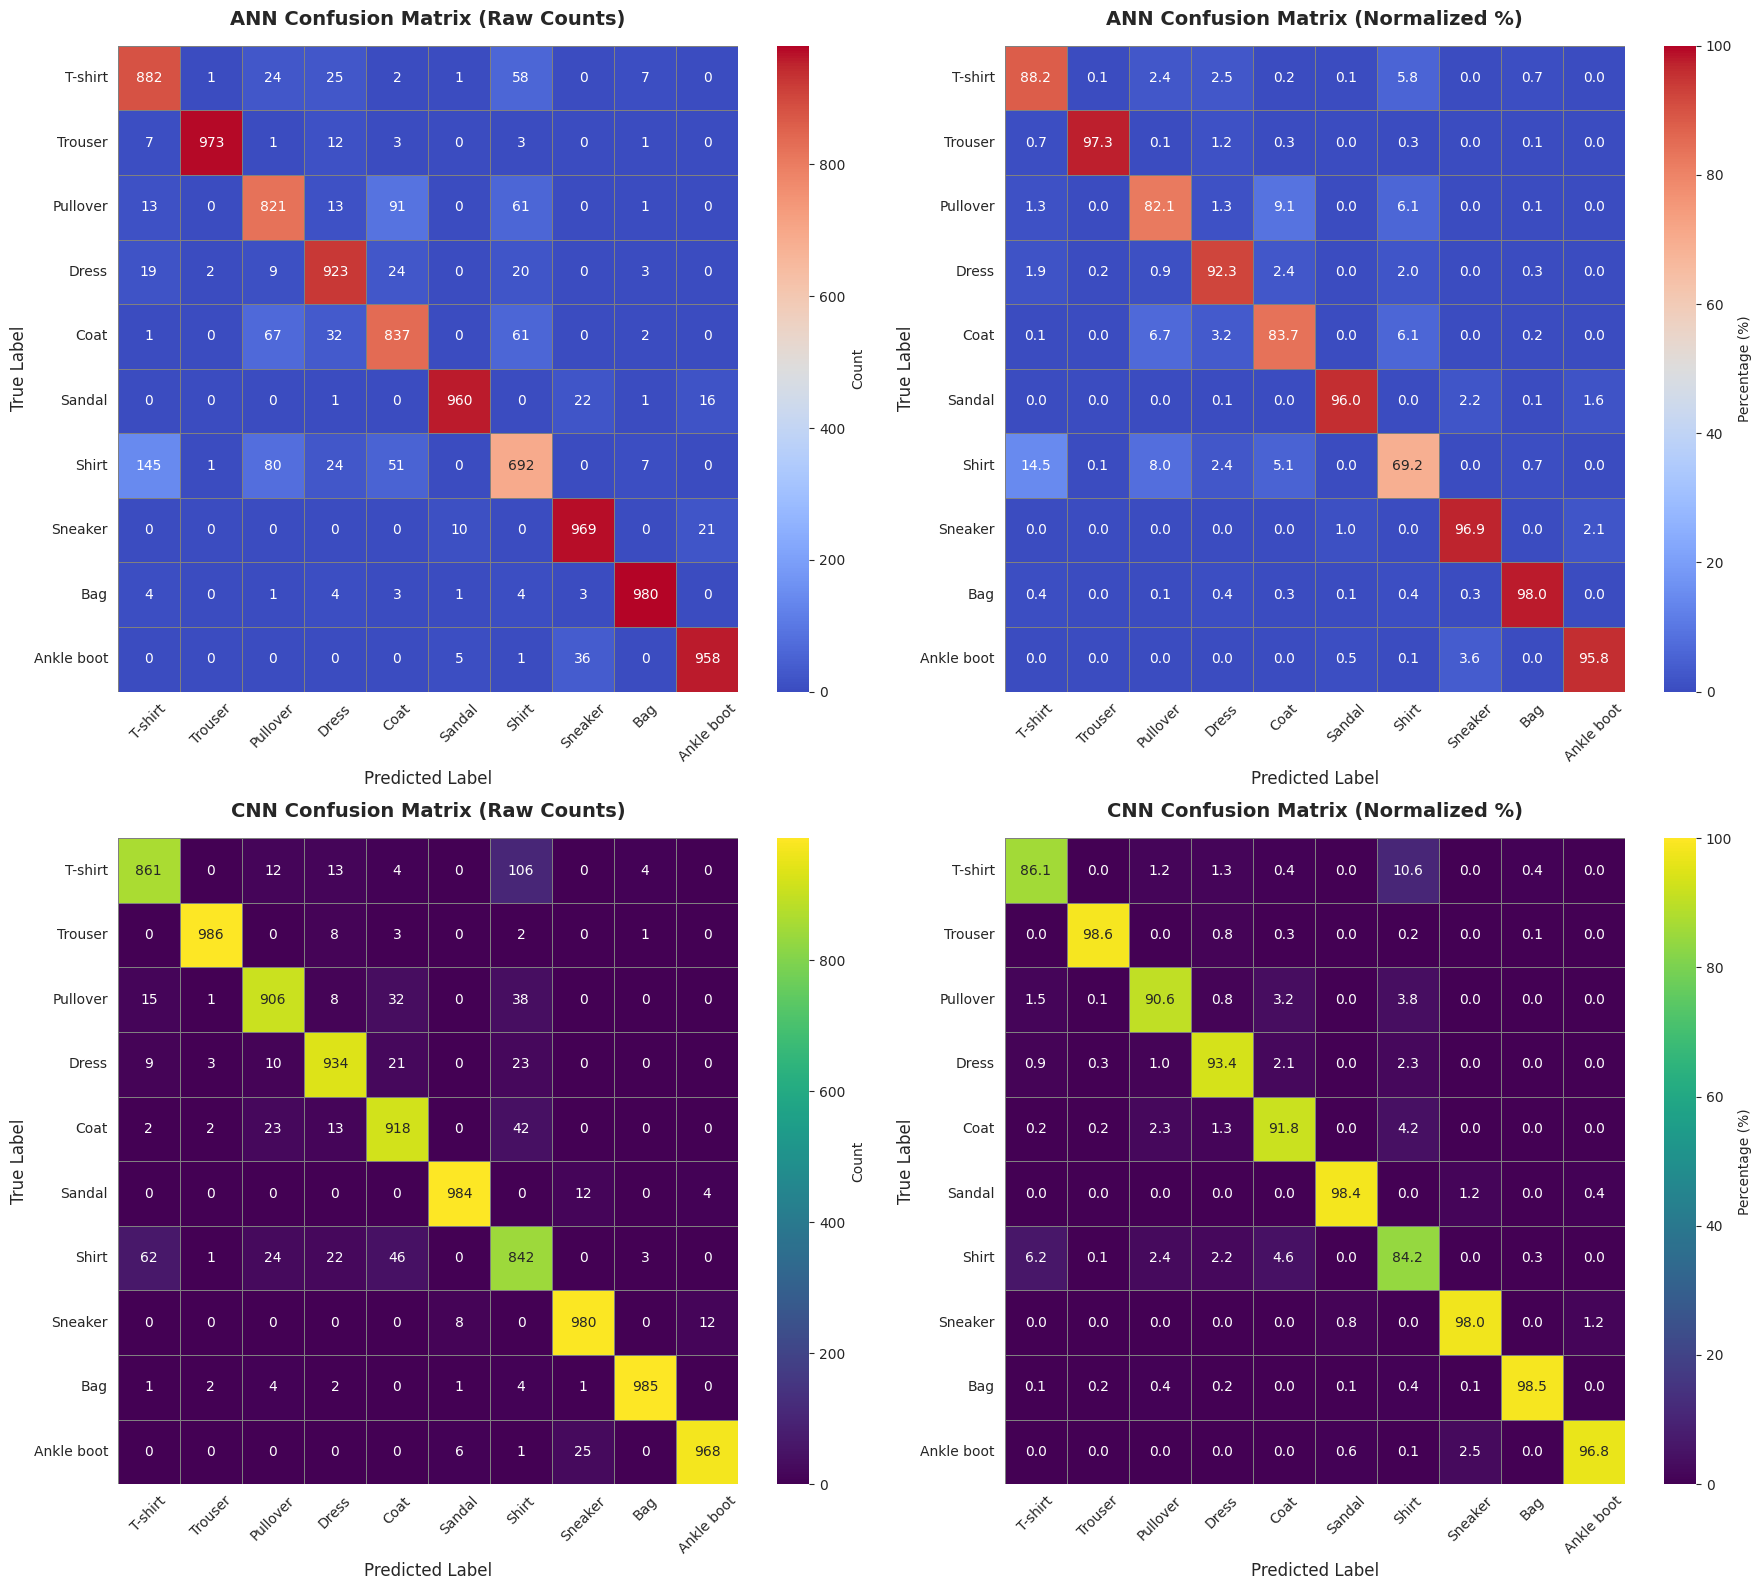


MOST CONFUSED CLASS PAIRS

ANN:
  Most confused pair: Shirt <-> T-shirt
  Number of errors: 145

CNN:
  Most confused pair: T-shirt <-> Shirt
  Number of errors: 106


In [13]:
# Confusion Matrices for Both ANN and CNN
# Calculate confusion matrices
ann_cm = confusion_matrix(ann_true, ann_pred)
cnn_cm = confusion_matrix(cnn_true, cnn_pred)

# Normalize confusion matrices for better visualization (percentages)
ann_cm_normalized = ann_cm.astype('float') / ann_cm.sum(axis=1)[:, np.newaxis]
cnn_cm_normalized = cnn_cm.astype('float') / cnn_cm.sum(axis=1)[:, np.newaxis]

# Create side-by-side comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# ANN Confusion Matrix (Raw counts)
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='coolwarm', ax=axes[0, 0],
           xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'},
           linewidths=0.5, linecolor='gray')
axes[0, 0].set_title('ANN Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold', pad=15)
axes[0, 0].set_ylabel('True Label', fontsize=12)
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].tick_params(axis='y', rotation=0)

# ANN Confusion Matrix (Normalized percentages)
sns.heatmap(ann_cm_normalized * 100, annot=True, fmt='.1f', cmap='coolwarm', ax=axes[0, 1],
           xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Percentage (%)'},
           linewidths=0.5, linecolor='gray', vmin=0, vmax=100)
axes[0, 1].set_title('ANN Confusion Matrix (Normalized %)', fontsize=14, fontweight='bold', pad=15)
axes[0, 1].set_ylabel('True Label', fontsize=12)
axes[0, 1].set_xlabel('Predicted Label', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].tick_params(axis='y', rotation=0)

# CNN Confusion Matrix (Raw counts)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='viridis', ax=axes[1, 0],
           xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'},
           linewidths=0.5, linecolor='gray')
axes[1, 0].set_title('CNN Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold', pad=15)
axes[1, 0].set_ylabel('True Label', fontsize=12)
axes[1, 0].set_xlabel('Predicted Label', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].tick_params(axis='y', rotation=0)

# CNN Confusion Matrix (Normalized percentages)
sns.heatmap(cnn_cm_normalized * 100, annot=True, fmt='.1f', cmap='viridis', ax=axes[1, 1],
           xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Percentage (%)'},
           linewidths=0.5, linecolor='gray', vmin=0, vmax=100)
axes[1, 1].set_title('CNN Confusion Matrix (Normalized %)', fontsize=14, fontweight='bold', pad=15)
axes[1, 1].set_ylabel('True Label', fontsize=12)
axes[1, 1].set_xlabel('Predicted Label', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Find most confused pairs for both models
print("\n" + "="*60)
print("MOST CONFUSED CLASS PAIRS")
print("="*60)

# ANN Analysis
ann_cm_copy = ann_cm.copy()
np.fill_diagonal(ann_cm_copy, 0)
ann_max_idx = np.unravel_index(ann_cm_copy.argmax(), ann_cm_copy.shape)
print(f"\nANN:")
print(f"  Most confused pair: {classes[ann_max_idx[0]]} <-> {classes[ann_max_idx[1]]}")
print(f"  Number of errors: {ann_cm[ann_max_idx]}")

# CNN Analysis
cnn_cm_copy = cnn_cm.copy()
np.fill_diagonal(cnn_cm_copy, 0)
cnn_max_idx = np.unravel_index(cnn_cm_copy.argmax(), cnn_cm_copy.shape)
print(f"\nCNN:")
print(f"  Most confused pair: {classes[cnn_max_idx[0]]} <-> {classes[cnn_max_idx[1]]}")
print(f"  Number of errors: {cnn_cm[cnn_max_idx]}")


In [14]:
# Detailed metrics for each class
print("\nCNN Classification Report:")
print(classification_report(cnn_true, cnn_pred, target_names=classes))



CNN Classification Report:
              precision    recall  f1-score   support

     T-shirt       0.91      0.86      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.93      0.91      0.92      1000
       Dress       0.93      0.93      0.93      1000
        Coat       0.90      0.92      0.91      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.80      0.84      0.82      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



## Model Comparison

Compare overall performance and per-class accuracy

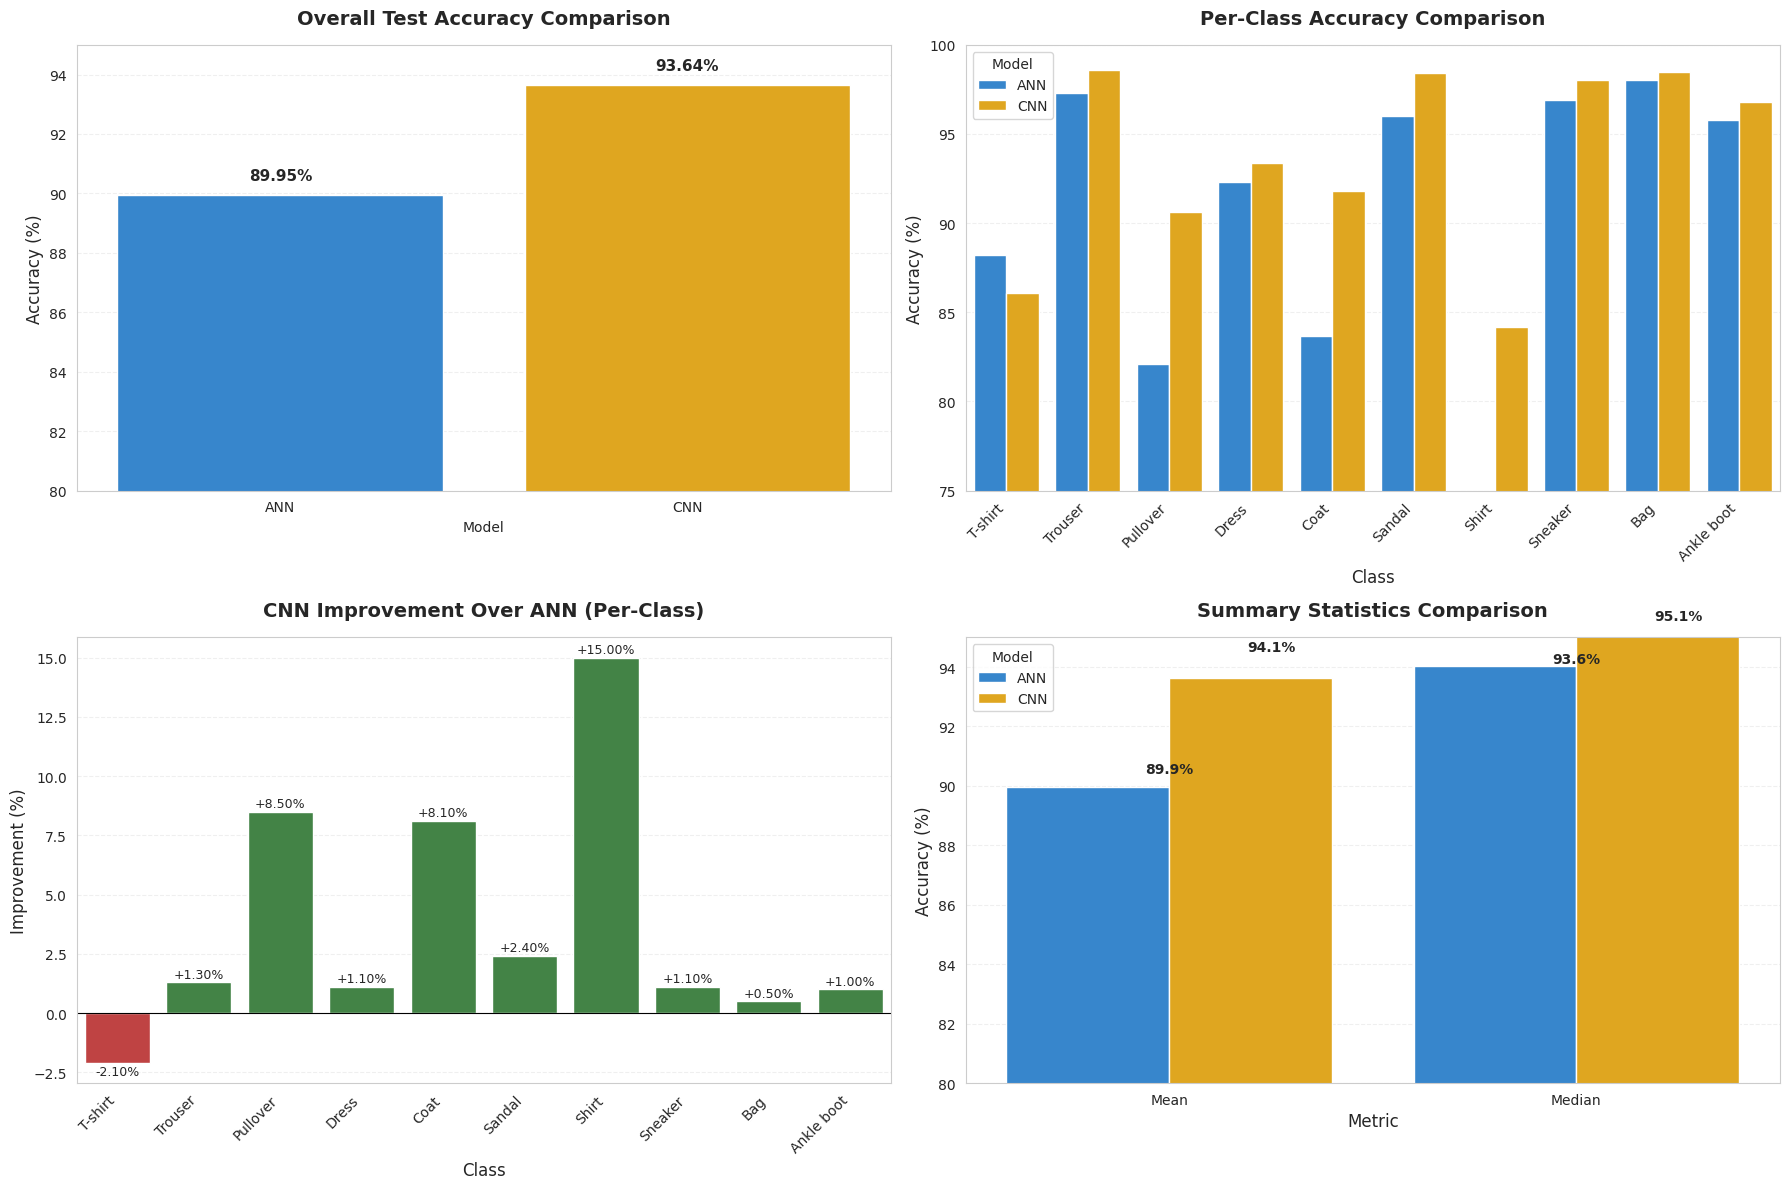


MODEL COMPARISON SUMMARY

Overall Accuracy:
  ANN: 89.95%
  CNN: 93.64%
  Improvement: +3.69%

Per-Class Performance (CNN):
  Best class: Trouser (98.60%)
  Worst class: Shirt (84.20%)

Per-Class Performance (ANN):
  Best class: Bag (98.00%)
  Worst class: Shirt (69.20%)

Average Per-Class Improvement: 3.69%

Per-Class Statistics:
  ANN - Mean: 89.95%, Median: 94.05%, Std: 8.82%
  CNN - Mean: 93.64%, Median: 95.10%, Std: 5.08%


In [15]:
# Advanced Model Comparison with Seaborn Barplots
# Calculate per-class accuracies
ann_cm = confusion_matrix(ann_true, ann_pred)
cnn_cm = confusion_matrix(cnn_true, cnn_pred)
ann_class_acc = ann_cm.diagonal() / ann_cm.sum(axis=1) * 100
cnn_class_acc = cnn_cm.diagonal() / cnn_cm.sum(axis=1) * 100

# Prepare data for seaborn
comparison_data = pd.DataFrame({
    'Class': classes * 2,
    'Accuracy': np.concatenate([ann_class_acc, cnn_class_acc]),
    'Model': ['ANN'] * len(classes) + ['CNN'] * len(classes)
})

# Create comprehensive comparison visualization with seaborn barplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Overall Accuracy Comparison with Seaborn Barplot
ax1 = axes[0, 0]
overall_data = pd.DataFrame({
    'Model': ['ANN', 'CNN'],
    'Accuracy': [ann_acc, cnn_acc]
})
sns.barplot(data=overall_data, x='Model', y='Accuracy', palette=['#1E88E5', '#FFB300'], ax=ax1)
ax1.set_title('Overall Test Accuracy Comparison', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_ylim([80, 95])
# Add value labels
for i, v in enumerate([ann_acc, cnn_acc]):
    ax1.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# 2. Per-Class Performance with Seaborn Barplot
ax2 = axes[0, 1]
sns.barplot(data=comparison_data, x='Class', y='Accuracy', hue='Model',
           palette=['#1E88E5', '#FFB300'], ax=ax2)
ax2.set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_xlabel('Class', fontsize=12)
ax2.set_xticklabels(classes, rotation=45, ha='right')
ax2.legend(title='Model', fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim([75, 100])

# 3. Improvement Analysis (CNN - ANN) with Seaborn Barplot
ax3 = axes[1, 0]
improvement = cnn_class_acc - ann_class_acc
improvement_df = pd.DataFrame({
    'Class': classes,
    'Improvement': improvement
})
# Use palette for colors based on positive/negative values
sns.barplot(data=improvement_df, x='Class', y='Improvement',
           palette=['#D32F2F' if x < 0 else '#388E3C' for x in improvement], ax=ax3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.set_title('CNN Improvement Over ANN (Per-Class)', fontsize=14, fontweight='bold', pad=15)
ax3.set_ylabel('Improvement (%)', fontsize=12)
ax3.set_xlabel('Class', fontsize=12)
ax3.set_xticklabels(classes, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels
for i, v in enumerate(improvement):
    ax3.text(i, v + (0.2 if v > 0 else -0.5), f'{v:+.2f}%', ha='center', fontsize=9)

# 4. Summary Statistics Comparison with Seaborn Barplot
ax4 = axes[1, 1]
summary_stats = pd.DataFrame({
    'Metric': ['Mean', 'Median'] * 2,
    'Value': [
        ann_class_acc.mean(), np.median(ann_class_acc),
        cnn_class_acc.mean(), np.median(cnn_class_acc)
    ],
    'Model': ['ANN', 'ANN', 'CNN', 'CNN']
})
sns.barplot(data=summary_stats, x='Metric', y='Value', hue='Model',
           palette=['#1E88E5', '#FFB300'], ax=ax4)
ax4.set_title('Summary Statistics Comparison', fontsize=14, fontweight='bold', pad=15)
ax4.set_ylabel('Accuracy (%)', fontsize=12)
ax4.set_xlabel('Metric', fontsize=12)
ax4.legend(title='Model', fontsize=10)
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.set_ylim([80, 95])
# Add value labels
ann_mean = ann_class_acc.mean()
ann_median = np.median(ann_class_acc)
cnn_mean = cnn_class_acc.mean()
cnn_median = np.median(cnn_class_acc)
ax4.text(0, ann_mean + 0.5, f'{ann_mean:.1f}%', ha='center', fontsize=10, fontweight='bold')
ax4.text(0.25, ann_median + 0.5, f'{ann_median:.1f}%', ha='center', fontsize=10, fontweight='bold')
ax4.text(1, cnn_mean + 0.5, f'{cnn_mean:.1f}%', ha='center', fontsize=10, fontweight='bold')
ax4.text(1.25, cnn_median + 0.5, f'{cnn_median:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical Summary
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(f"\nOverall Accuracy:")
print(f"  ANN: {ann_acc:.2f}%")
print(f"  CNN: {cnn_acc:.2f}%")
print(f"  Improvement: +{cnn_acc - ann_acc:.2f}%")

print(f"\nPer-Class Performance (CNN):")
worst_idx = cnn_class_acc.argmin()
best_idx = cnn_class_acc.argmax()
print(f"  Best class: {classes[best_idx]} ({cnn_class_acc[best_idx]:.2f}%)")
print(f"  Worst class: {classes[worst_idx]} ({cnn_class_acc[worst_idx]:.2f}%)")

print(f"\nPer-Class Performance (ANN):")
ann_worst_idx = ann_class_acc.argmin()
ann_best_idx = ann_class_acc.argmax()
print(f"  Best class: {classes[ann_best_idx]} ({ann_class_acc[ann_best_idx]:.2f}%)")
print(f"  Worst class: {classes[ann_worst_idx]} ({ann_class_acc[ann_worst_idx]:.2f}%)")

print(f"\nAverage Per-Class Improvement: {improvement.mean():.2f}%")
print(f"\nPer-Class Statistics:")
print(f"  ANN - Mean: {ann_class_acc.mean():.2f}%, Median: {np.median(ann_class_acc):.2f}%, Std: {ann_class_acc.std():.2f}%")
print(f"  CNN - Mean: {cnn_class_acc.mean():.2f}%, Median: {np.median(cnn_class_acc):.2f}%, Std: {cnn_class_acc.std():.2f}%")


## Sample Predictions

Visualize some predictions to see where model succeeds/fails

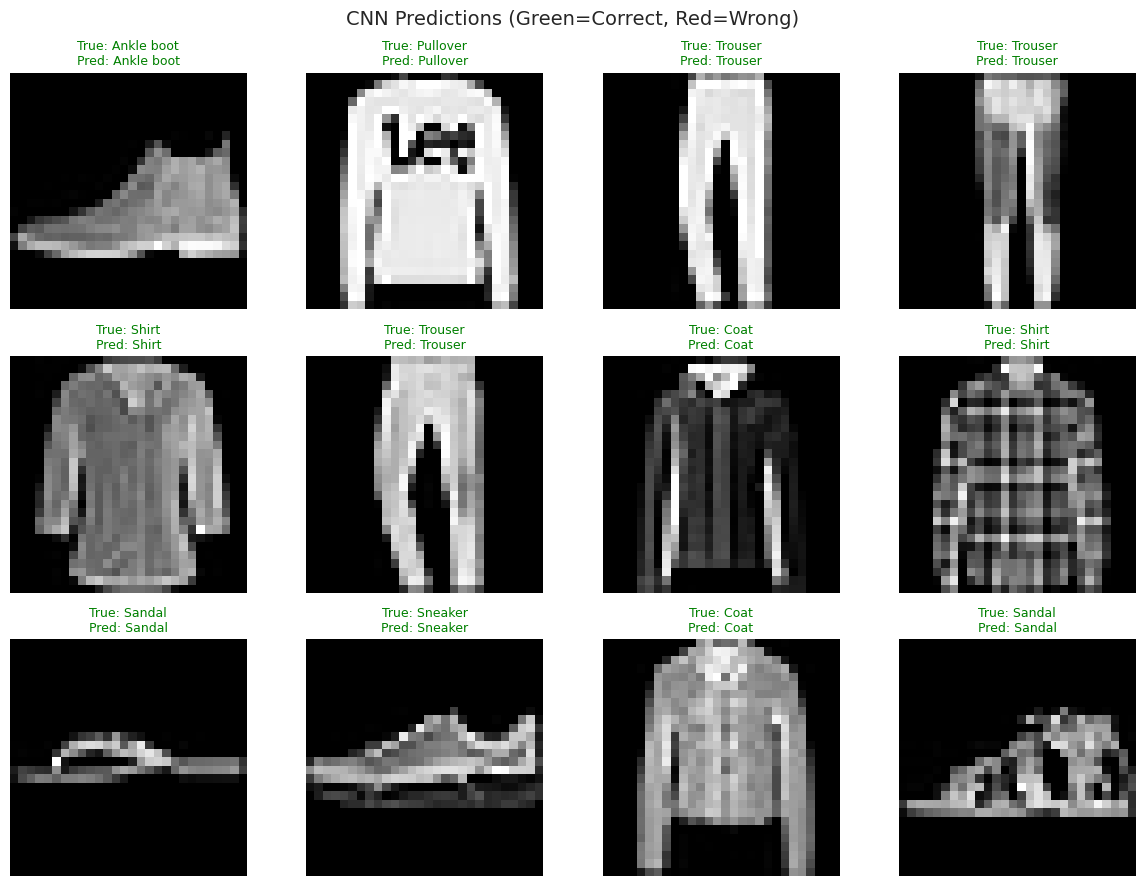

In [16]:
# Show predictions on sample images
cnn.eval()
imgs, labels = next(iter(test_loader))
imgs, labels = imgs[:12], labels[:12]  # take first 12 images

# Get predictions
with torch.no_grad():
    outputs = cnn(imgs.to(device))
    _, preds = outputs.max(1)

# Display images with predictions
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    # Denormalize image for display
    img = imgs[i].squeeze() * std + mean
    ax.imshow(img.cpu(), cmap='gray')

    true_label = labels[i].item()
    pred_label = preds[i].item()

    # Green if correct, red if wrong
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}",
                color=color, fontsize=9)
    ax.axis('off')

plt.suptitle('CNN Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.show()


## Summary & Conclusions

**Results:**
- CNN achieved ~92% accuracy (3-4% better than ANN)
- CNN has fewer parameters but learns better spatial features
- Main confusion between similar clothing items (Shirt/T-shirt, Coat/Pullover)

**Why CNN works better:**
- Convolutional layers learn local patterns (edges, textures)
- Weight sharing makes model more efficient
- Hierarchical feature learning (low-level → high-level)


---
Roll Number: P2929935

Student Name: Faseeh Bin Ali
